# Binary Classification: Northern Flicker vs House Finch (CNN)

This notebook builds and evaluates a compact CNN to distinguish between Northern Flicker and House Finch using spectrogram data. It includes architecture visualization, loss and MAE curves, and evaluation metrics.


In [1]:
# 1. Load Data and Filter for Two Species

import h5py
import numpy as np

# Load preprocessed splits (replace path as needed)
with h5py.File('../data/bird_spectrograms_splits.hdf5', 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_val = f['X_val'][:]
    y_val = f['y_val'][:]
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

# Encoded species labels:
# {'amecro': 0, 'amerob': 1, 'bewwre': 2, 'bkcchi': 3, 'daejun': 4,
#  'houfin': 5, 'houspa': 6, 'norfli': 7, 'rewbla': 8, 'sonspa': 9,
#  'spotow': 10, 'whcspa': 11}

norfli_label = 7  # Northern Flicker
houfin_label = 5  # House Finch

def filter_binary(X, y, class0, class1):
    mask = (y == class0) | (y == class1)
    X_bin = X[mask]
    y_bin = y[mask]
    # Relabel: class0 -> 0 (Northern Flicker), class1 -> 1 (House Finch)
    y_bin = (y_bin == class1).astype(int)
    return X_bin, y_bin

X_train_bin, y_train_bin = filter_binary(X_train, y_train, norfli_label, houfin_label)
X_val_bin, y_val_bin = filter_binary(X_val, y_val, norfli_label, houfin_label)
X_test_bin, y_test_bin = filter_binary(X_test, y_test, norfli_label, houfin_label)

print(f"Train: {X_train_bin.shape}, Validation: {X_val_bin.shape}, Test: {X_test_bin.shape}")
print("Label mapping: 0 = Northern Flicker, 1 = House Finch")


Train: (178, 343, 256), Validation: (39, 343, 256), Test: (39, 343, 256)
Label mapping: 0 = Northern Flicker, 1 = House Finch


## 2. Visualize Example Spectrograms


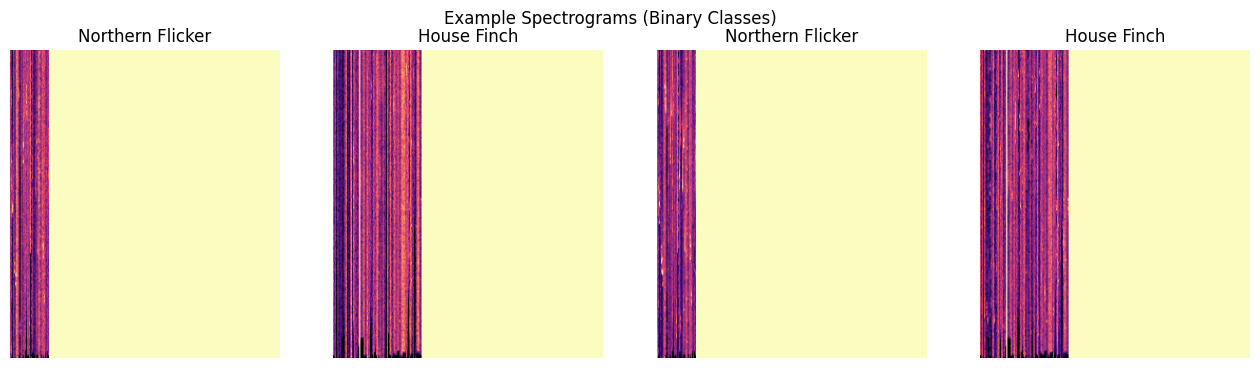

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train_bin))
    label = y_train_bin[idx]
    ax.imshow(X_train_bin[idx], aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"{'House Finch' if label else 'Northern Flicker'}")
    ax.axis('off')
plt.suptitle("Example Spectrograms (Binary Classes)")
plt.show()


## 3. Build the CNN Model (Matching Diagram)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = X_train_bin.shape[1:]  # (343, 256)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((343, 256, 1)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 343, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 343, 256, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 171, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 171, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 85, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Visualize the Model Architecture


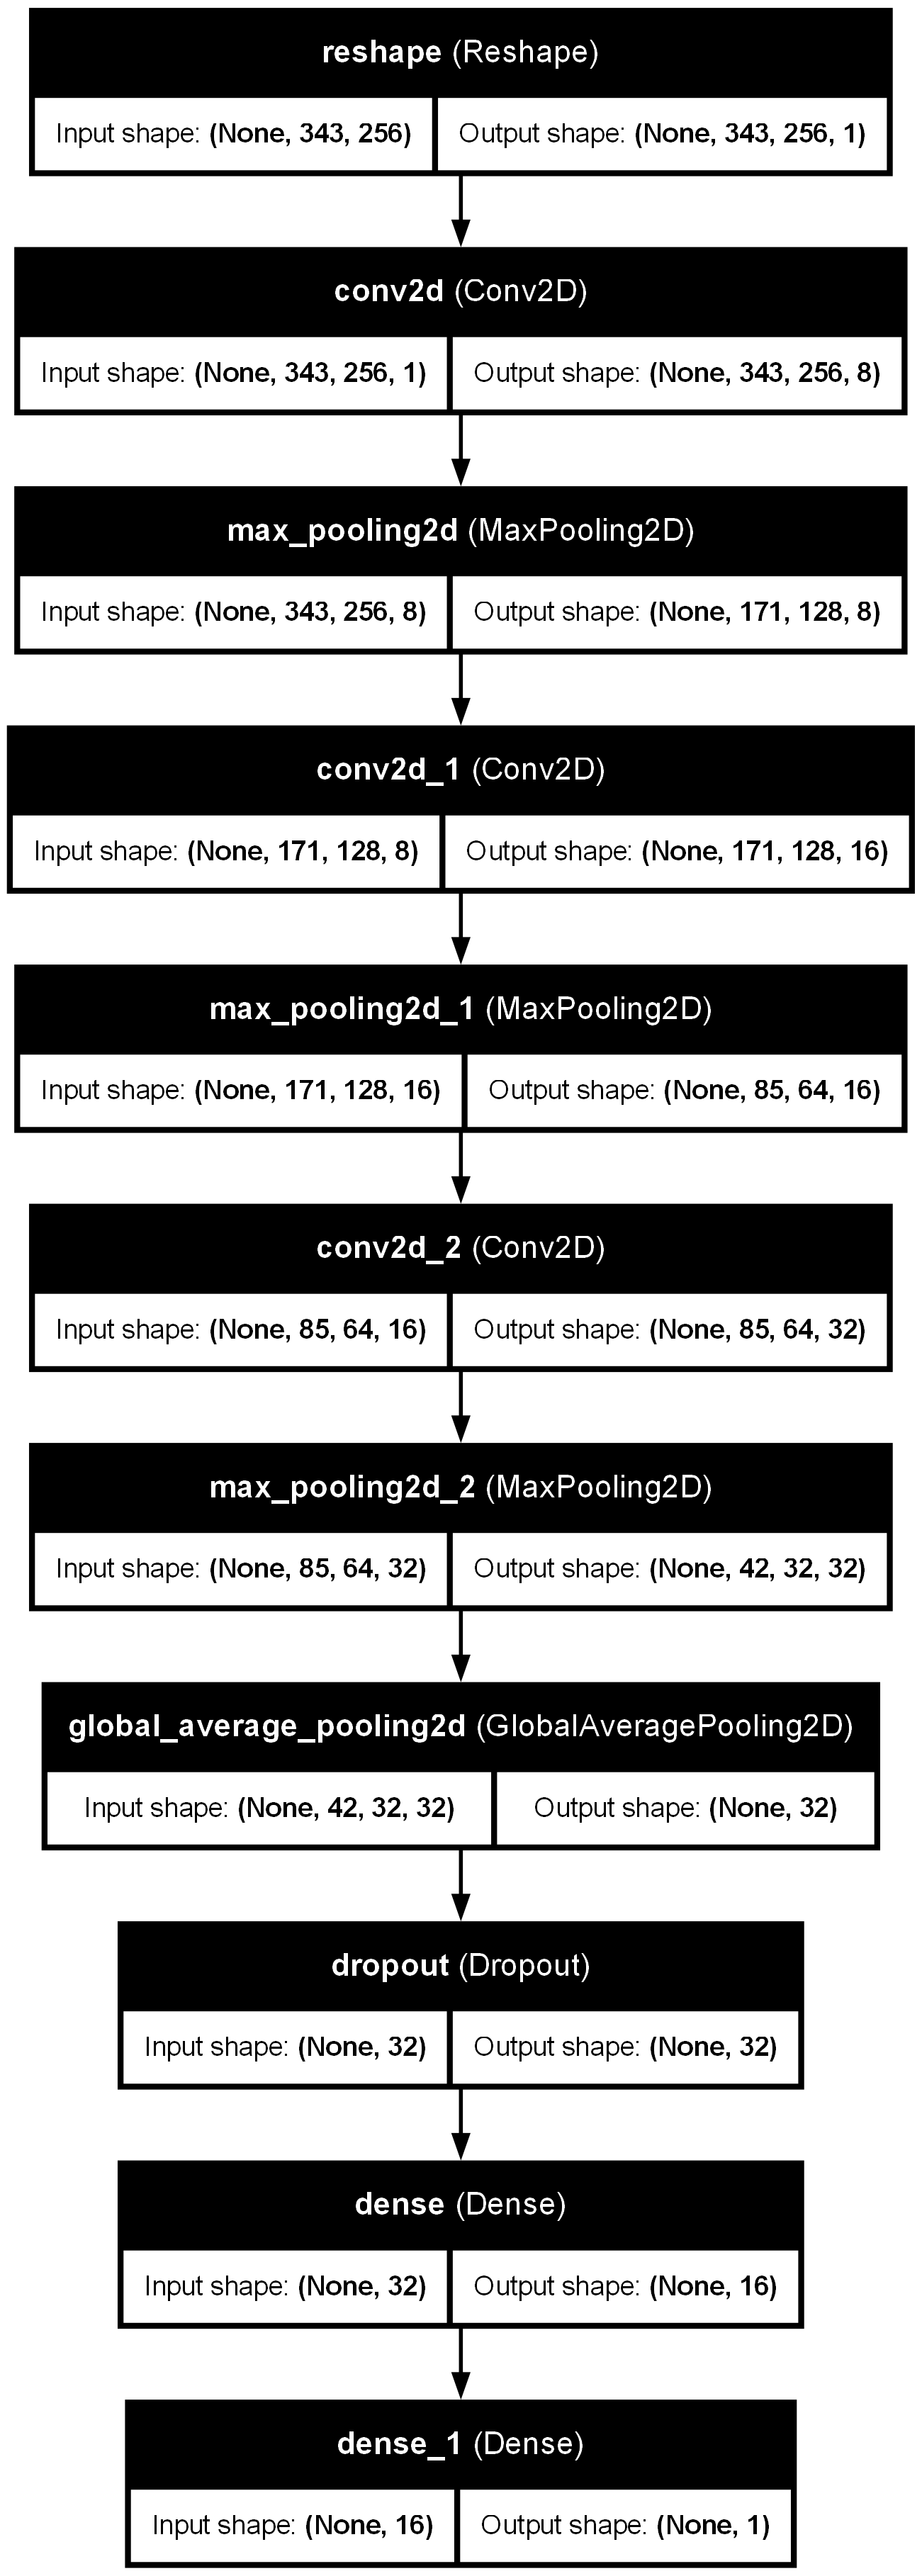

In [4]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='binary_cnn_architecture.png', show_shapes=True, show_layer_names=True)
Image('binary_cnn_architecture.png')


## 5. Train the Model


In [5]:
history = model.fit(
    X_train_bin, y_train_bin,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin)
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.4603 - loss: 0.6912 - mae: 0.4988 - val_accuracy: 0.4872 - val_loss: 0.6919 - val_mae: 0.4992
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.5337 - loss: 0.6925 - mae: 0.4994 - val_accuracy: 0.5385 - val_loss: 0.6881 - val_mae: 0.4974
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5138 - loss: 0.6902 - mae: 0.4983 - val_accuracy: 1.0000 - val_loss: 0.6843 - val_mae: 0.4956
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6171 - loss: 0.6849 - mae: 0.4957 - val_accuracy: 1.0000 - val_loss: 0.6775 - val_mae: 0.4921
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6975 - loss: 0.6753 - mae: 0.4908 - val_accuracy: 1.0000 - val_loss: 0.6687 - val_mae: 0.4876
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6745 - loss: 0.6668 - mae: 0.4862 - val_accuracy: 1.0000 - val_loss: 0.6548 - val_mae: 0.4804
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - 

## 6. Plot Loss and MAE Curves


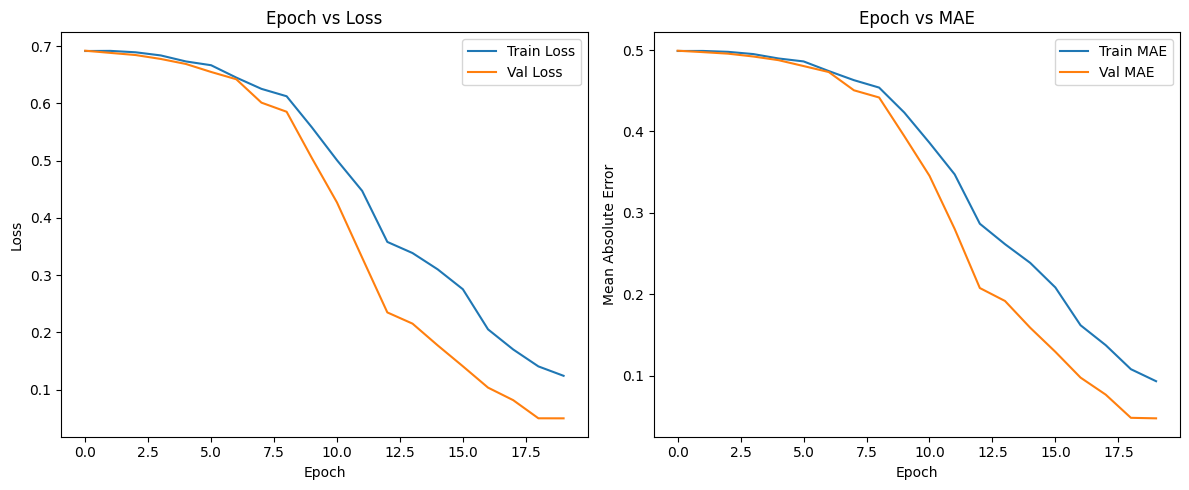

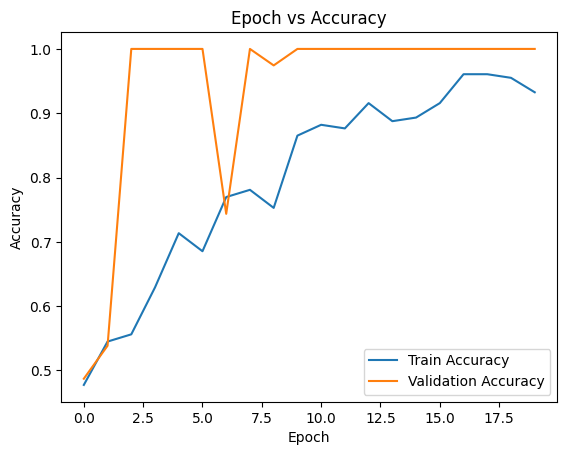

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

mae_key = 'mae' if 'mae' in history.history else 'mean_absolute_error'
val_mae_key = 'val_mae' if 'val_mae' in history.history else 'val_mean_absolute_error'
plt.subplot(1, 2, 2)
plt.plot(history.history[mae_key], label='Train MAE')
plt.plot(history.history[val_mae_key], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Epoch vs MAE')
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()


## 7. Evaluate the Model


In [7]:
test_loss, test_acc, test_mae = model.evaluate(X_test_bin, y_test_bin, verbose=2)
print(f"Test accuracy: {test_acc:.3f}, Test MAE: {test_mae:.3f}")


2/2 - 0s - 41ms/step - accuracy: 1.0000 - loss: 0.0575 - mae: 0.0540
Test accuracy: 1.000, Test MAE: 0.054


## 8. Confusion Matrix and Classification Report


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test_bin) > 0.5).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred, target_names=['Northern Flicker', 'House Finch']))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Confusion Matrix:
[[20  0]
 [ 0 19]]

Classification Report:
                  precision    recall  f1-score   support

Northern Flicker       1.00      1.00      1.00        20
     House Finch       1.00      1.00      1.00        19

        accuracy                           1.00        39
       macro avg       1.00      1.00      1.00        39
    weighted avg       1.00      1.00      1.00        39



## 9. Save Model


In [9]:
model.save('../models/binary_norfli_houfin_cnn_small_model.h5')
